In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
documents_train = pd.read_csv("/content/drive/MyDrive/cheers_challenge/round1/data_round_1/documents_en_train.csv")
sentences_train = pd.read_csv("/content/drive/MyDrive/cheers_challenge/round1/data_round_1/sentences_en_train.csv")

documents_val = pd.read_csv("/content/drive/MyDrive/cheers_challenge/round1/data_round_1/documents_en_val.csv")
sentences_val = pd.read_csv("/content/drive/MyDrive/cheers_challenge/round1/data_round_1/sentences_en_val.csv")

documents_test = pd.read_csv("/content/drive/MyDrive/cheers_challenge/round1/data_round_1/documents_en_test.csv")
sentences_test = pd.read_csv("/content/drive/MyDrive/cheers_challenge/round1/data_round_1/sentences_en_test.csv")

with open("/content/drive/MyDrive/cheers_challenge/round1/data_round_1/word_embedding.txt", "rb") as fp: 
    embedding_distilbert = pickle.load(fp)

with open("/content/drive/MyDrive/cheers_challenge/round1/data_round_1/attention_masks.txt", "rb") as fp: 
    attention_masks = pickle.load(fp)

#immap_sector_name_to_id.json

In [58]:
#if 'Unnamed: 0' in embedding_distilbert.columns:
#    embedding_distilbert = embedding_distilbert.drop(labels='Unnamed: 0', axis = 1)

## Investigate Document data

In [59]:
documents_train.head()

,project_name,country_code,lang_code,doc_id,doc_text,doc_url
0,IMMAP/DFS Syria,SYR,en,48582,This website uses cookies to improve your expe...,https://www.syriahr.com/en/203844/
1,IMMAP/DFS Syria,SYR,en,41032,Please enable Cookies and reload the page.\n\n...,https://www.syriahr.com/en/187230/
2,IMMAP/DFS Burkina Faso,BFA,en,41306,When Burkina Faso’s government called for civi...,https://www.thenewhumanitarian.org/news-featur...
3,IMMAP/DFS Syria,SYR,en,43779,DAMASCUS – The United Nations World Food Progr...,https://reliefweb.int/report/syrian-arab-repub...
4,IMMAP/DFS Nigeria,NGA,en,42212,Overview The continuation of conflict in North...,https://reliefweb.int/sites/reliefweb.int/file...


## Investigate full text data

In [60]:
sentences_train.head()

,doc_id,sentence_id,sentence_text,is_relevant,sector_ids
0,51657,0,New Salesian youth center in La Cecilia distri...,0,[]
1,51657,1,Armenia is at the center of the Colombian coff...,0,[]
2,51657,2,The new youth center has served more than 100 ...,0,[]
3,51657,3,The Salesian youth center was developed in res...,0,[]
4,51657,4,Many of these youth come from poor families an...,0,[]


In [61]:
counts = sentences_train[["sentence_id", "doc_id"]].groupby("doc_id").count()
print("Median sentence lenght of document:", np.median(counts))
counts

Median sentence lenght of document: 24.0


,sentence_id
doc_id,
34512,126
34513,296
34547,750
34549,65
34550,36
...,...
51845,4
51850,22
51851,3


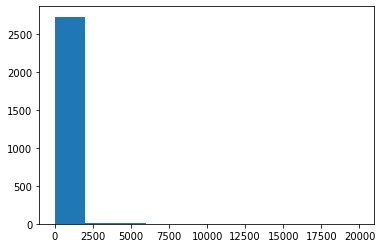

In [62]:
import matplotlib.pyplot as plt
counts = sentences_train.groupby("doc_id").count()
x = counts["sentence_id"]
plt.hist(x)
plt.show()

In [63]:
all_sectors = []
string_list = ["[", "]", ",", " "]
for topics in sentences_train["sector_ids"]:
    for topic in topics:
        if topic not in string_list:
            all_sectors.append(topic)        

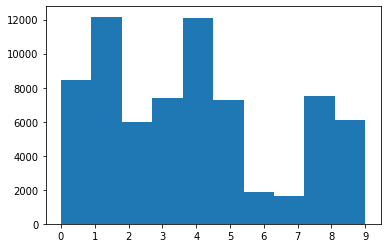

In [64]:
plt.hist(sorted(all_sectors))
plt.show()

In [65]:
sentences = sentences_train["sentence_text"]

In [66]:
len(sentences)

261981

In [67]:
!pip install transformers

In [68]:
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig
configuration = DistilBertConfig(max_position_embeddings = 1024)

# Initializing a model from the configuration
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")
encoded_input = tokenizer(sentences[0], return_tensors='tf')
output = model(encoded_input)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [69]:
print(tokenizer.tokenize(sentences[0]))

['new', 'sales', '##ian', 'youth', 'center', 'in', 'la', 'cecilia', 'district', 'serves', 'more', 'than', '100', 'youth', '(', 'mission', '##ne', '##ws', '##wire', ')', 'sales', '##ian', 'missionaries', 'have', 'opened', 'a', 'youth', 'center', 'in', 'the', 'la', 'cecilia', 'district', 'of', 'armenia', ',', 'colombia', '.']


In [70]:
print(sentences[0])

New Salesian youth center in La Cecilia district serves more than 100 youth (MissionNewswire) Salesian missionaries have opened a youth center in the La Cecilia district of Armenia, Colombia.


In [71]:
!pip install keras

In [72]:
from keras.preprocessing.sequence import pad_sequences

input_ids = pad_sequences(embedding_distilbert, maxlen=128 , truncating="post", padding="post")

In [73]:
labels = sentences_train["is_relevant"]

In [86]:
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, test_size=0.2, random_state = 123)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, test_size=0.1, random_state = 123)

In [85]:
train_labels

1

In [100]:
train_labels.index.get_loc(8)

31764

In [87]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Deciding the batch size for training.

batch_size = 32

#DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# DataLoader for our validation(test) set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

KeyError: ignored